# `kickscore` basics

This notebook introduces the library's API in the context of a simple example involving [Tom and Jerry](https://en.wikipedia.org/wiki/Tom_and_Jerry).

![Tom and Jerry](https://media.giphy.com/media/rjZii4RTL6I0M/giphy.gif)

In this notebook, we will:

1. instantiate a `kickscore` model,
2. define items & express our prior beliefs on the temporal dynamics of the items' skill,
3. fit the model to a toy dataset, and
4. analyze the results.

If you are not doing so already, you can [launch an interactive notebook on Google Colaboratory](https://colab.research.google.com/github/lucasmaystre/kickscore/blob/master/examples/kickscore-basics.ipynb)

In [ ]:
# This is only needed for when running the notebook on Google Colaboratory.
!pip install kickscore

In [1]:
import kickscore as ks
%matplotlib inline

## Defining & fitting the model

First, we define the model. In this example, we will use a _binary_ model, which is suitable for observations of the type "_A_ wins over _B_".
Richer types of observations can be handled with `TernaryModel`, `CountModel` and `DifferenceModel`.

In [2]:
model = ks.BinaryModel()

We will observe outcomes of "fights" between three contestants: Tom (the cat), Jerry (the mouse) and Spike (the dog).
Each contestant is an _item_, in `kickscore`'s terminology.

The key assumption behind the `kickscore` models is that the outcome probability of each fight is a function of the (latent) skill of each contestant.
This skill can **change over time**.
For each contestant, we need to describe how we expect their skill to change over time.
We do this by specifying a **kernel function** (a.k.a. covariance function).

- Many kernel functions have a variance parameter (usually called `var`). Roughly speaking, this defines the range of possible skill values.
- Some kernel functions have a lengthscale parameter (usually called `lscale`). This roughly defines the time interval over which we expect the skill to stay similar.

In [3]:
# Spike's skill does not change over time.
k_spike = ks.kernel.Constant(var=0.5)

# Tom's skill changes over time, with "jagged" (non-smooth) dynamics.
k_tom = ks.kernel.Exponential(var=1.0, lscale=1.0)

# Jerry's skill has a constant offset and smooth dynamics.
k_jerry = ks.kernel.Constant(var=1.0) + ks.kernel.Matern52(var=0.5, lscale=1.0)

# Now we are ready to add the items in the model.
model.add_item("Spike", kernel=k_spike)
model.add_item("Tom", kernel=k_tom)
model.add_item("Jerry", kernel=k_jerry)

Next, we add observations to the model. **Note that observations must be added in chronological order.** The `observe` method takes:

- a list containing the items that _won_ the comparison (`winners`)
- a list containing the items that _lost_ the comparison (`losers`)
- the time of the observation (`t`)

When `winners` or `losers` contains more than one item, `kickscore` considers the _sum of the corresponding items' skill_.

In [4]:
# At first, Jerry beats Tom a couple of times.
model.observe(winners=["Jerry"], losers=["Tom"], t=0.0)
model.observe(winners=["Jerry"], losers=["Tom"], t=0.9)

# Then, Tom beats Spike, and then Jerry.
model.observe(winners=["Tom"], losers=["Spike"], t=1.7)
model.observe(winners=["Tom"], losers=["Jerry"], t=2.1)

# Finally, Jerry beats Tom, and then Tom + Spike.
model.observe(winners=["Jerry"], losers=["Tom"], t=3.0)
model.observe(winners=["Jerry"], losers=["Tom", "Spike"], t=3.5)

Now we are ready to fit the model (i.e., infer the skill parameters over time).

In [5]:
model.fit(verbose=True)

iteration 1, max diff: 0.69315
iteration 2, max diff: 0.80824
iteration 3, max diff: 0.11764
iteration 4, max diff: 0.04363
iteration 5, max diff: 0.00419
iteration 6, max diff: 0.00166
iteration 7, max diff: 0.00027


True

## Analyzing the results

We can get a good understanding of what the model learned by plotting the skill as a function of time.

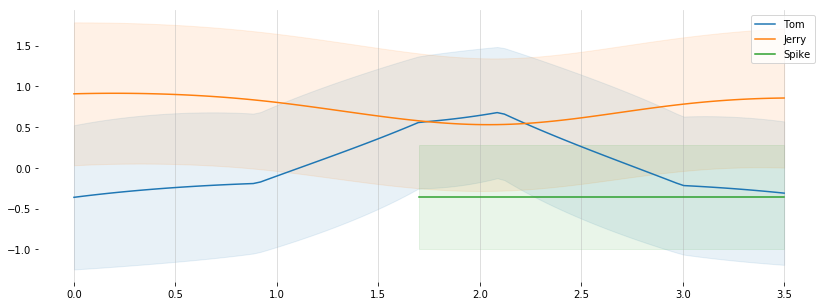

In [6]:
model.plot_scores(["Tom", "Jerry", "Spike"], figsize=(14, 5));

As `kickscore` learns a posterior _distribution_ over the skills, we represent the mean skill (solid line) as well as the region corresponding to one standard deviation (the shaded area).

Notice the following:

- the skill of Tom is not smooth over time. Notice how the bends happen at moments corresponding to observations involving Tom.
- in contrast, the skill of Jerry varies smoothly.
- The skill of Spike is constant, as expected.

We can also use the model to make predictions for any combination of items, at any time point.

In [7]:
# We can predict a future outcome...
p_win, p_los = model.probabilities(["Jerry"], ["Tom"], t=4.0)
print("Chances that Jerry beats Tom at t = 4.0: {:.1f}%".format(100*p_win))

# ... or simulate what could have happened in the past.
p_win, p_los = model.probabilities(["Jerry"], ["Tom"], t=2.0)
print("Chances that Jerry beats Tom at t = 2.0: {:.1f}%".format(100*p_win))

p_win, p_los = model.probabilities(["Jerry"], ["Tom"], t=-1.0)
print("Chances that Jerry beats Tom at t = -1.0: {:.1f}%".format(100*p_win))

Chances that Jerry beats Tom at t = 4.0: 73.0%
Chances that Jerry beats Tom at t = 2.0: 47.1%
Chances that Jerry beats Tom at t = -1.0: 70.3%


Finally, note that we had to make quite a few choices when we set up the model.
In particular, we had to explicitly choose the kernel functions and their (hyper)paramaters.

A principled way to compare various models and to eventually select the best one is to compare the log-marginal likelihood of the data (the higher, the better).

In [8]:
model.log_likelihood

-4.050817554668693

You can go back and change the kernels & their parameters. Can you find a better model than the one we picked?